## Classificazione dello stato fetale attraverso la cardiotocografia

#  1. Contesto

La cardiotocografia è la tecnica che aiuta i medici a tracciare la frequenza cardiaca del feto,che include la misurazione delle accelerazioni, decelerazioni e variabilità, con l'aiuto delle contrazioni uterine. Può essere sfruttata per classificare lo stato di salute del feto.
Il data set che è stato utilizzato in questo progetto è costituito da 2126 records ognuno deiquali è stato associato da un team di Ostetrici ad una classe di stato fetale specifica. Abbiamo:

- 1655 Normali
- 295 Sospetti
- 176 Patologici



**Obiettivo**

L’obiettivo è quello di costruire un algoritmo di classificazione. Nel dettaglio ci troviamo di fronte ad un problema supervisionato di Classificazione Multiclasse


**Schema dei dati**

Informazioni degli attributi:

LB - FHR baseline (battiti al minuto)
AC - # delle accellerazione al secondo
FM - # dei movimenti fetali al secondo
UC - # delle contrazioni uterini al secondo
DL - # delle decellerazioni leggere al secondo
DS - # delle decellerazioni severe al secondo
DP - # delle decellerazioni continuate al secondo
ASTV - percentuale di tempo con variabilità anormale a breve termine
MSTV - valore medio della variabilità a breve termine
ALTV - percentuale di tempo con variabilità anormale a lungo termine
MLTV - valore medio della variabilità a lungo termine
Width - larghezza dell'istogramma FHR
Min - minimo dell'istogramma FHR
Max - massimo dell'istogramma FHR
Nmax - numero di picchi dell'istogramma
Nzeros - numero di zeri dell'istogramma
Mode - modalità dell'istogramma
Media - media dell'istogramma
Median - mediana dell'istogramma
Variance - varianza dell'istogramma
Tendenza - tendenza dell'istogramma

# 2. Modello Applicato sua analisi

In [49]:
#Import delle librerie
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

SEED = 42

In [50]:
path_input = "data"
dataset = "dataset.csv"

df = pd.read_csv(path_input + "/" + dataset, sep = ";", decimal = ",")

**Prime Analisi**

In [51]:
df.isnull().sum()

LB          0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

In [52]:
df.describe()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003170,0.009474,0.004357,0.001885,0.000004,0.000157,46.990122,1.332785,9.84666,...,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003860,0.046670,0.002940,0.002962,0.000063,0.000580,17.192814,0.883241,18.39688,...,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.001876,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.001630,0.000000,0.004482,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.005631,0.002512,0.006525,0.003264,0.000000,0.000000,61.000000,1.700000,11.00000,...,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019284,0.480634,0.014925,0.015385,0.001353,0.005348,87.000000,7.000000,91.00000,...,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


<AxesSubplot:xlabel='NSP', ylabel='Count'>

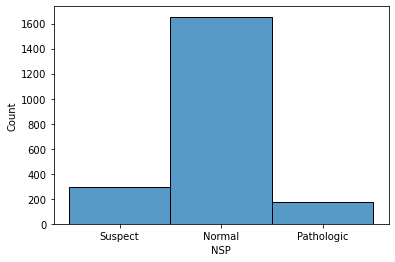

In [53]:
#Display dell'istogramma della classe target
sns.histplot(df['NSP'])

**Primi Risultati**

- Valori Nulli
    - Non sono presenti valori nulli nelle feature

- Attributi
    - Gli attributi sono tutti numerici e non hanno la stessa scala

- Target Class
    - La classe target non è distribuita uniformemente essendoci un maggior numero di valori **Normal**.


In [57]:
#X --> Attributi, Y --> Variabile Target

x = df.drop(columns = ["NSP"])

features_name = x.columns

y = df["NSP"]

**Modello iniziale**

In [58]:
#Effettuo lo split tra train & test stratificando sulla variabile target

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y,  test_size=0.3, random_state=SEED)

In [59]:
#Applico l'albero decisionale con i parametri di defaul di sciki-learn
clf_DTC = DecisionTreeClassifier(random_state=SEED)
clf_DTC.fit(X_train, y_train)

#Calcolo le Y predette dal madello per effettuare la valutazione
y_pred_DTC = clf_DTC.predict(X_test)

In [60]:
# Report di classificazione
print(metrics.classification_report(y_pred_DTC, y_test))

              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95       507
  Pathologic       0.94      0.93      0.93        54
     Suspect       0.66      0.75      0.70        77

    accuracy                           0.92       638
   macro avg       0.85      0.87      0.86       638
weighted avg       0.92      0.92      0.92       638



In [61]:
print("Numero di Nodi:",clf_DTC.tree_.node_count)

Numero di Nodi: 177


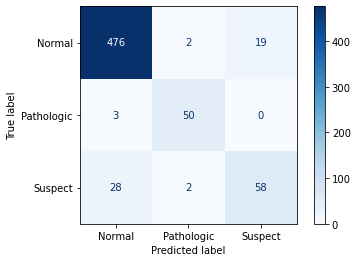

In [62]:
#Visulizzo la matrice di confusione 3X3
metrics.plot_confusion_matrix(clf_DTC, X_test, y_test, cmap = plt.cm.Blues)
plt.show()

Risultati del modello sono interessanti. Voglio diminuire il numero degli attributi per diminuire la complessità del problema cercando di non perdere l'accouratezza e se possibile aumentarla

# 2. Scelta finale dell dell'approccio e analisi del risultato

Essendo un problema di natura medica potrebbe essere utile fornire un modello che abbia un accuratezza simile ma che sia di più facile interpretazione. Per fare questo seleziono gli attributi più importanti e provo a fornire direttamente le soglie dell'albero decisionale all'utente.

In [63]:
def plot_importance(importance,names,model_type):
  #Creo 2 array dagli attributi più importanti e dai nomi degli attributi
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Creo un dataframe
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Ordino il dataframe
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Salvo gli attributi principali ordinati che la funzione mi deve restituire
  feature_most_imp = list(fi_df[fi_df['feature_importance']>0]['feature_names'].values)

  plt.figure(figsize=(10,8))
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  plt.title(model_type + ' Caratteristiche Principali')
  plt.xlabel('Importanza')
  plt.ylabel('Nome Caratteristica')

  return feature_most_imp

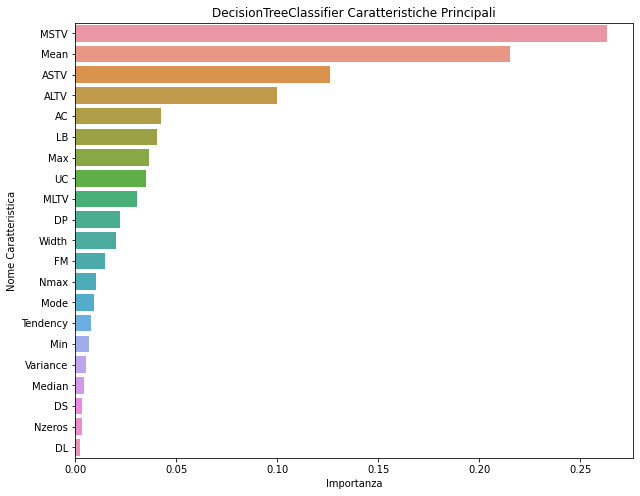

In [64]:
feature_to_select = plot_importance(importance=clf_DTC.feature_importances_,
                                    names=features_name,
                                    model_type= clf_DTC.__class__.__name__)

In [65]:
#Graficamente vedo che le princiapali sono le prime 4
feature_to_select = feature_to_select[:4]

In [66]:
feature_to_select

['MSTV', 'Mean', 'ASTV', 'ALTV']

Identificate i principali attributi voglio trovare il set ideale (nel nostro caso) di iperapametri. Applico il metodo GridSearchCV

In [67]:
#Combinazione di parametri da testare
tree_para = {'criterion':['gini','entropy'],
             'max_depth':list(range(1,10))}

In [68]:
#Applico GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(), param_grid= tree_para, cv = 10, verbose= 1, n_jobs=-1)

In [69]:
grid.fit(X_train[feature_to_select], y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             verbose=1)

In [70]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 6}

In [73]:
#Passo gli iperparametri trovati all'Albero Decisionale e effetuato la valutazione del modello
clf_DTC_FS = DecisionTreeClassifier(random_state=SEED, criterion=grid.best_params_["criterion"],max_depth= grid.best_params_["max_depth"])
clf_DTC_FS.fit(X_train[feature_to_select], y_train)
y_pred_DTC_FS = clf_DTC_FS.predict(X_test[feature_to_select])

In [74]:
# Classification Report

print(metrics.classification_report(y_pred_DTC_FS, y_test))

              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95       517
  Pathologic       0.91      0.92      0.91        52
     Suspect       0.67      0.86      0.75        69

    accuracy                           0.92       638
   macro avg       0.85      0.90      0.87       638
weighted avg       0.93      0.92      0.93       638



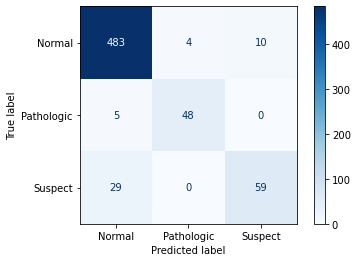

In [75]:
metrics.plot_confusion_matrix(clf_DTC_FS, X_test[feature_to_select], y_test, cmap = plt.cm.Blues)
plt.show()

In [76]:
print("Numero di Nodi:",clf_DTC_FS.tree_.node_count)

Numero di Nodi: 71


L'Accuratezza della soluzione è migliorata. A questo punto storicizzo l'albero decisionale per fornire eventualmente le soglie di classificazione.

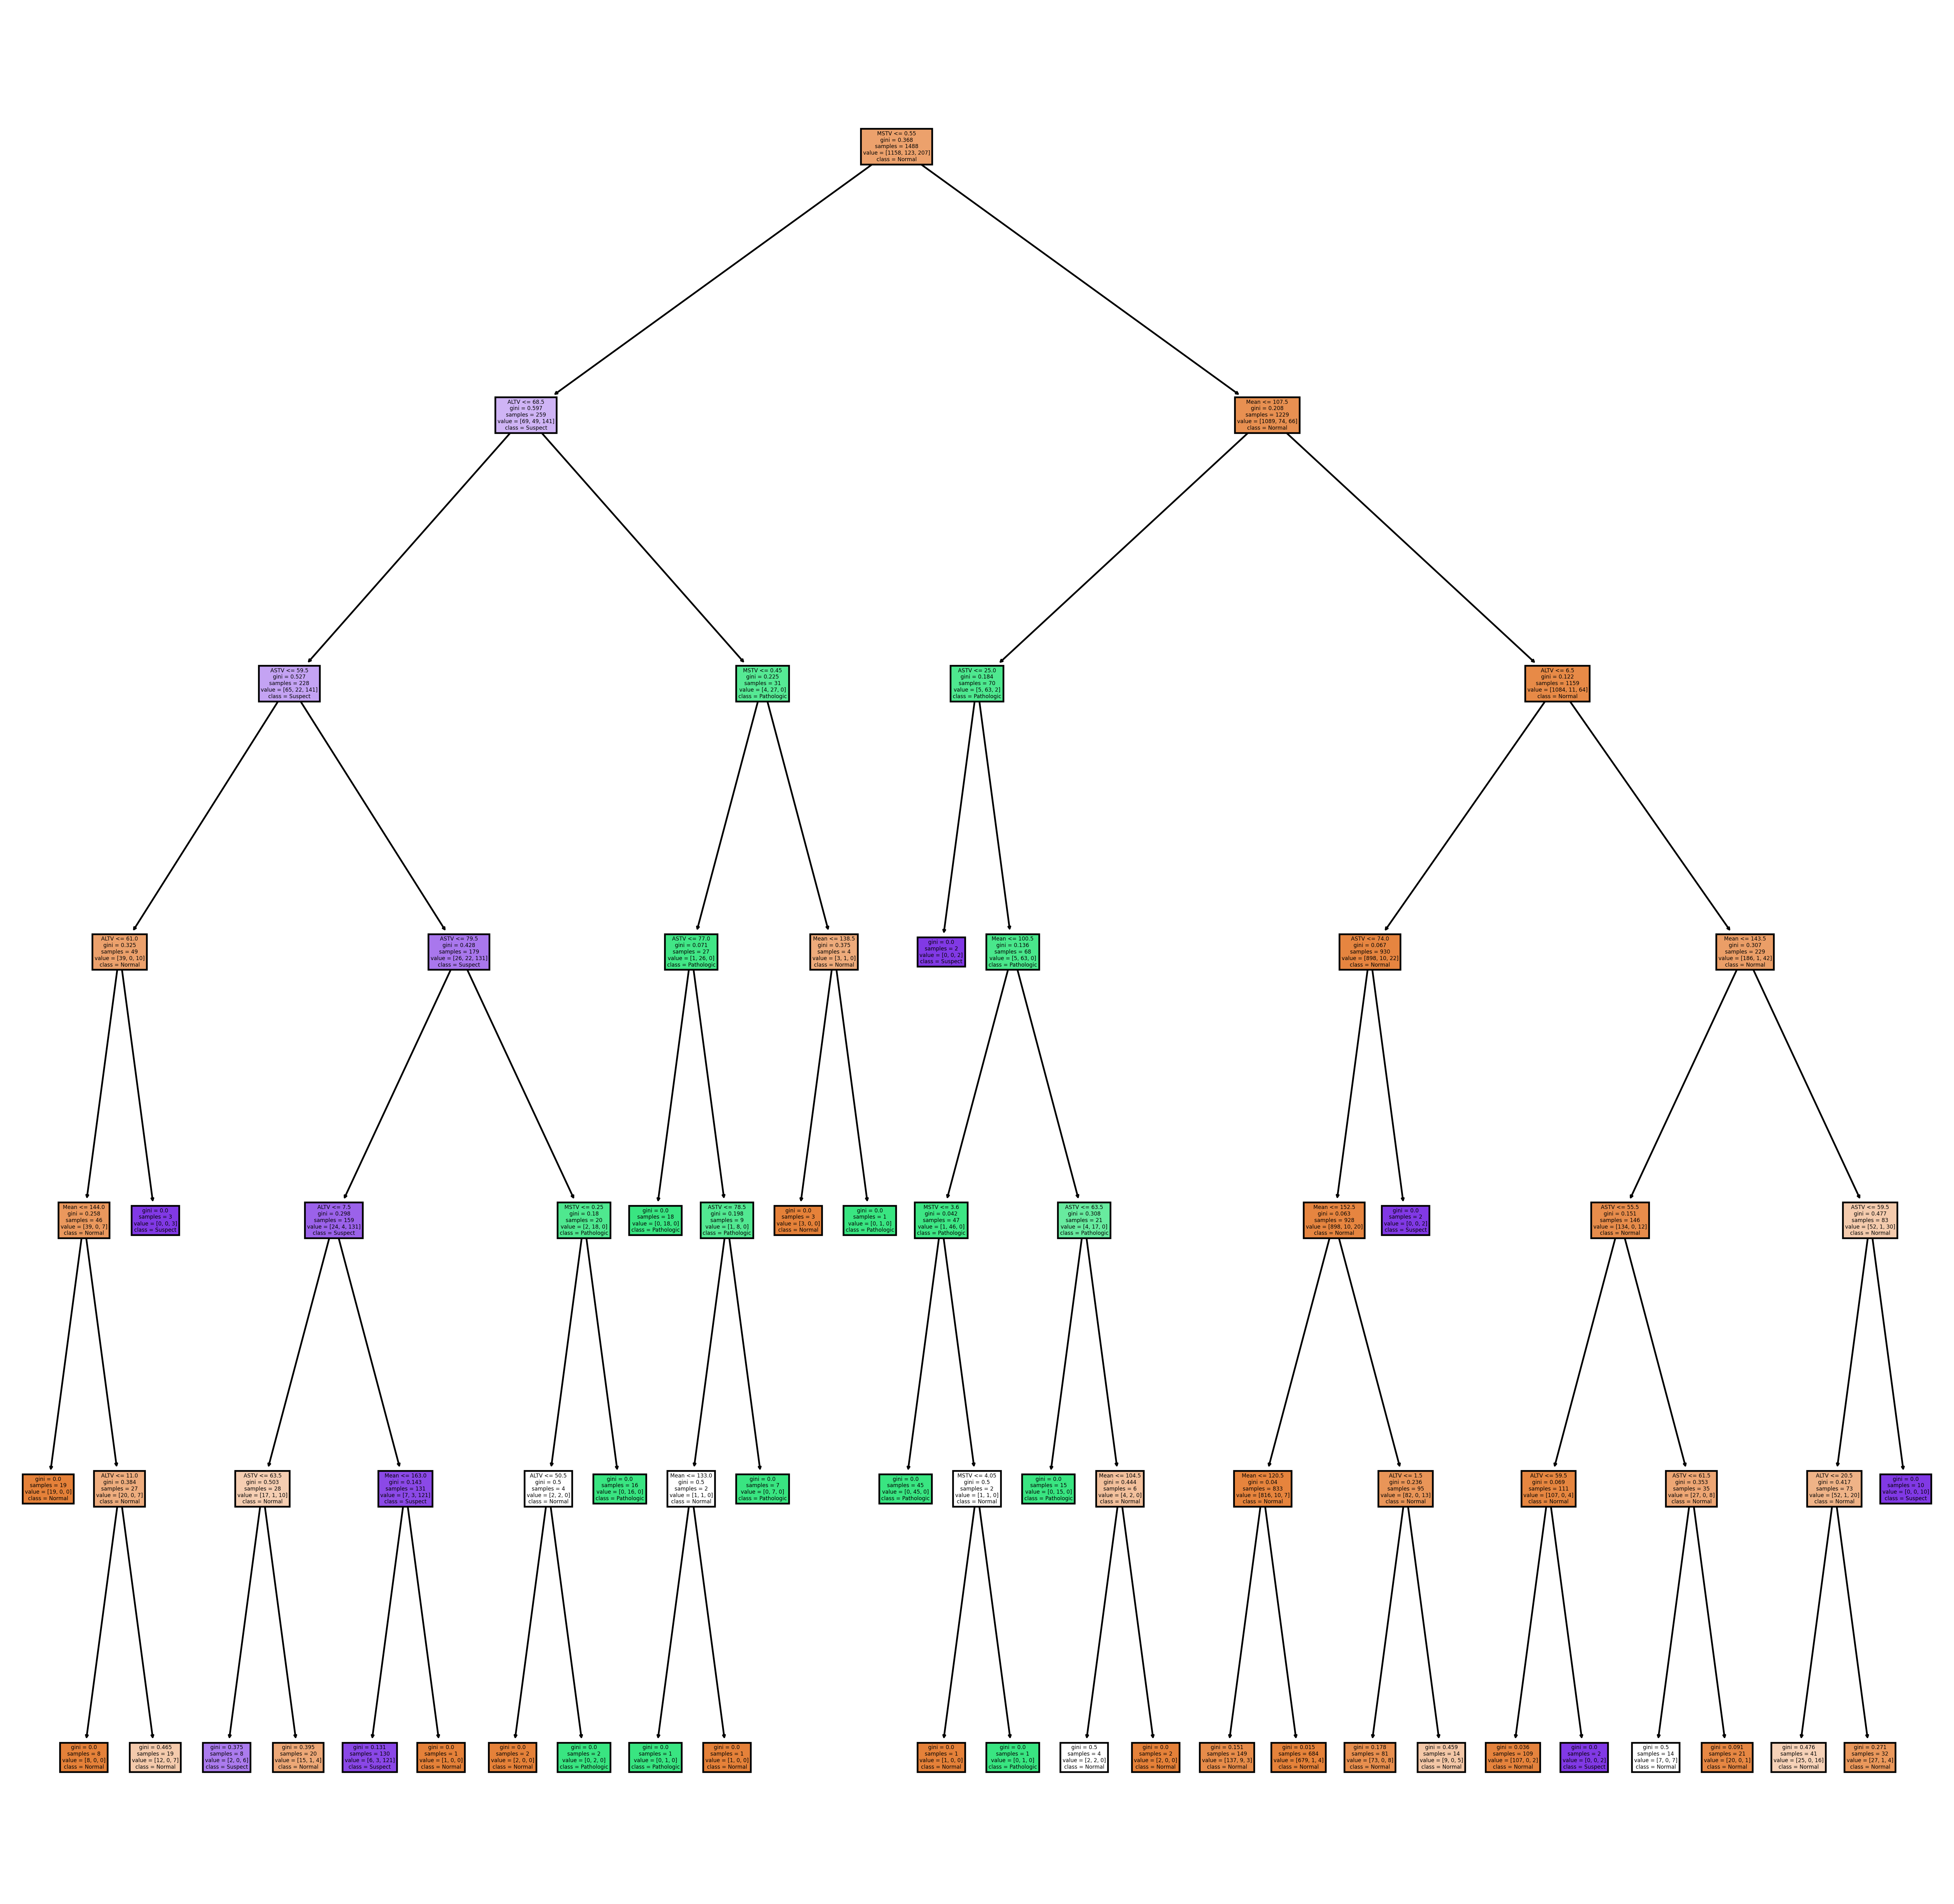

In [26]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=400)
tree.plot_tree(clf_DTC_FS,
               feature_names = feature_to_select,
               class_names=["Normal", "Pathologic", "Suspect"],
               filled = True)
fig.savefig('output/AlberoDecisionale.png')

Salvo il modello creato con pickle.

In [27]:
import pickle
filename = 'output/modello_finale.sav'
pickle.dump(clf_DTC_FS, open(filename, 'wb'))